## 1. Importing Dependancies

In [109]:
import os

import lightgbm as lgb
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from scipy import stats
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestRegressor,
    StackingRegressor,
    VotingRegressor,
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from xgboost import XGBRegressor

## 2. Load and Prepare Data

In [110]:
df = pd.read_csv("/home/kobey/Documents/DATASCIENCE/PROJECTS/TITANIC DATASET/data/01-raw/Titanic-Dataset.csv")
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [111]:
df.shape

(891, 12)

### 2.1. Make all columns lowercase

In [112]:
# Convert all columns to lowercase
df = df.rename(columns=str.lower)
df

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## 3. Train, Test and Validation Split

In [113]:
# dependent and Independent variables/features
y = df['survived'] # target data
X = df.drop('survived',axis=1) # feature data

# first split: train + temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# second split: validation + test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

In [114]:
X_train.shape

(623, 11)

In [115]:
X_val.shape

(134, 11)

In [116]:
X_test.shape

(134, 11)

#### Class Balance

In [117]:
y.mean()

np.float64(0.3838383838383838)

In [118]:
y_train.mean()

np.float64(0.38362760834670945)

In [119]:
y_val.mean()

np.float64(0.3880597014925373)

In [120]:
y_test.mean()

np.float64(0.3805970149253731)

#### Check if survived is present in X

In [121]:
'Survived' in X_train.columns

False

#### Check that indices don’t overlap

In [122]:
set(X_train.index) & set(X_val.index)
set(X_train.index) & set(X_test.index)

set()

###  3.1 Save the split up data

In [123]:
X_train.to_csv("data/02-split/X_train.csv", index=False) 
y_train.to_csv("data/02-split/y_train.csv", index=False)
X_val.to_csv("data/02-split/X_val.csv", index=False)
y_val.to_csv("data/02-split/y_val.csv", index=False)
X_test.to_csv("data/02-split/X_test.csv", index=False)
y_test.to_csv("data/02-split/y_test.csv", index=False)

## 4. Initial Exploration

In [124]:
df.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [125]:
df.describe()

,passengerid,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<Axes: >

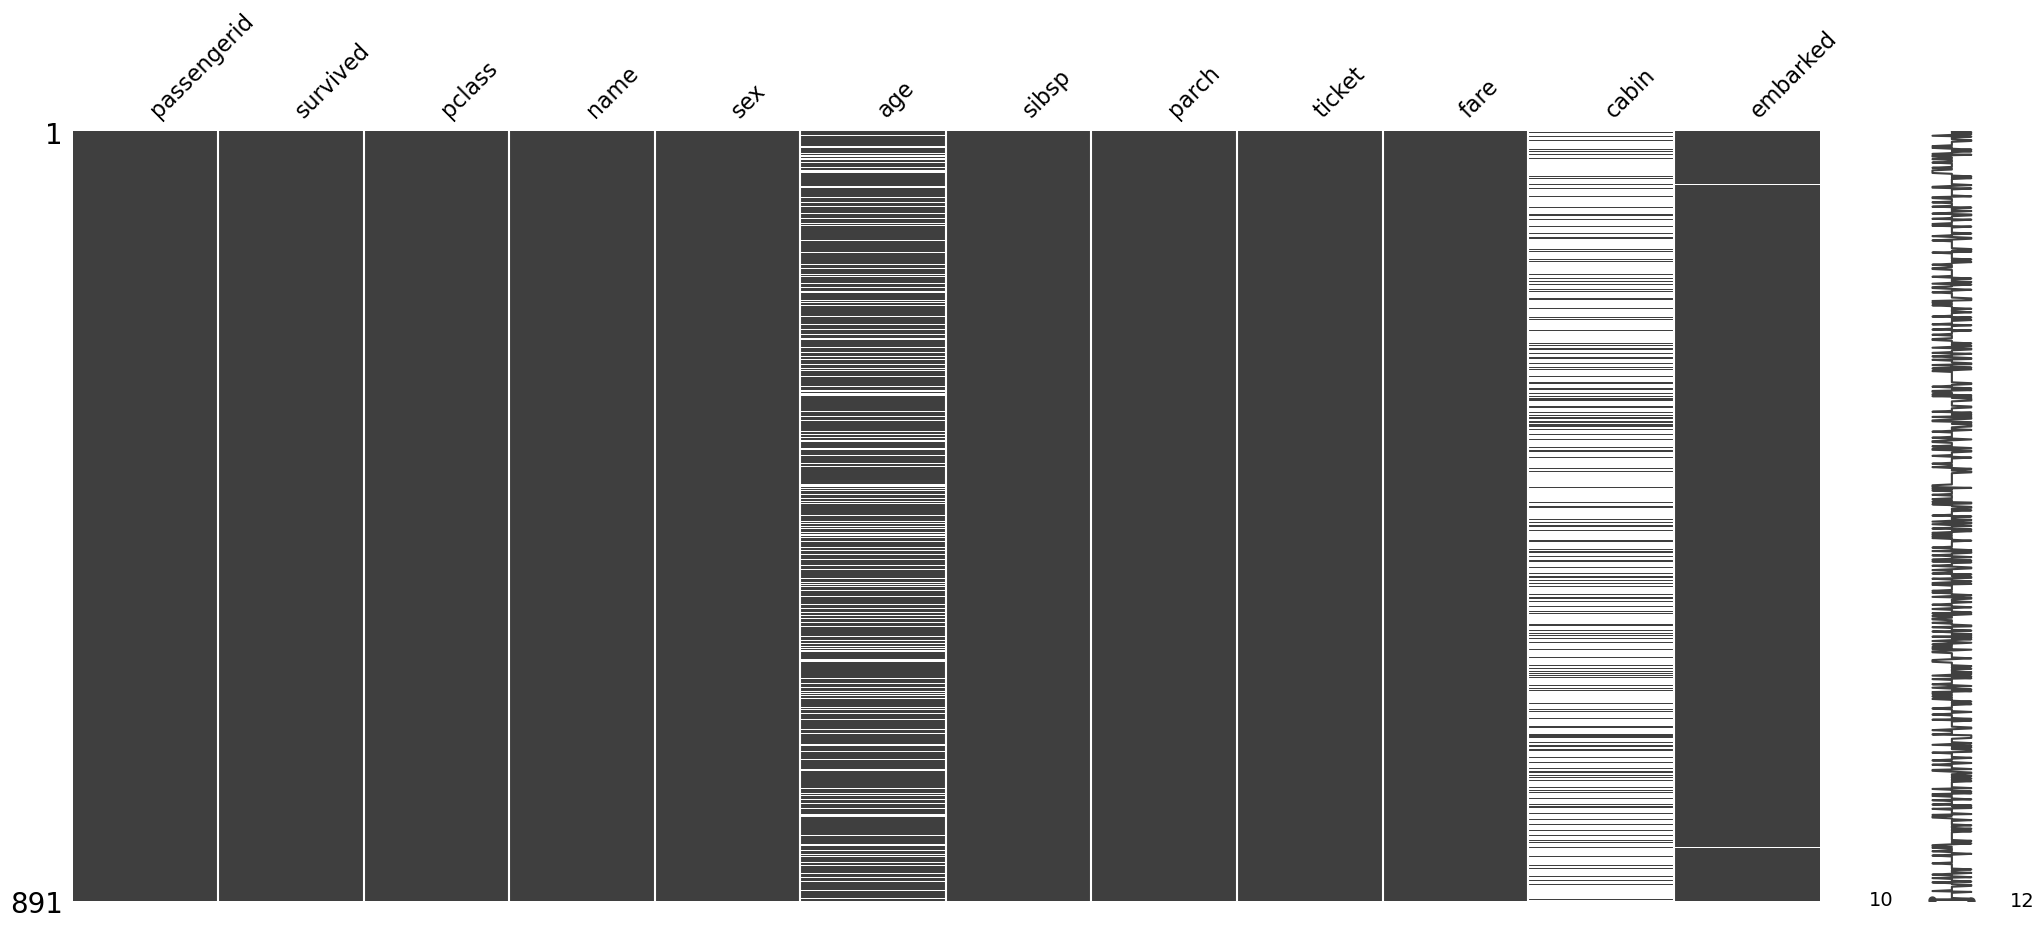

In [126]:
msno.matrix(df)

In [127]:
df.dtypes

passengerid      int64
survived         int64
pclass           int64
name            object
sex             object
age            float64
sibsp            int64
parch            int64
ticket          object
fare           float64
cabin           object
embarked        object
dtype: object

In [128]:
df.isnull().sum()

passengerid      0
survived         0
pclass           0
name             0
sex              0
age            177
sibsp            0
parch            0
ticket           0
fare             0
cabin          687
embarked         2
dtype: int64

### 4.1 Dealing with Missing Data

#### i. Fill The Missing Ages

In [129]:
# 1. Create a "Lookup Dictionary" from the training data
# This converts the medians into a simple python dict: {(1, 'male'): 40.0, ...}
median_dict = X_train.groupby(['pclass', 'sex'])['age'].median().to_dict()

# 2. Define the function that works on a SINGLE ROW
def fill_age(row):
    # If age is missing (NaN), look it up
    if pd.isna(row['age']):
        # Create a key tuple from this row's data
        key = (row['pclass'], row['sex'])
        # Return the median from our dict
        return median_dict.get(key, row['age'])
    
    # If age is already there, keep it
    return row['age']

# 3. Apply it to all dataframes
# We assign the result back to the 'age' column
for df in [X_train, X_val, X_test]:
    df['age'] = df.apply(fill_age, axis=1)

In [130]:
df['age'].isna().sum()

np.int64(0)

In [131]:
df

,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
455,456,3,"Jalsevac, Mr. Ivan",male,29.0,0,0,349240,7.8958,NaN,C
607,608,1,"Daniel, Mr. Robert Williams",male,27.0,0,0,113804,30.5000,NaN,S
142,143,3,"Hakkarainen, Mrs. Pekka Pietari (Elin Matilda ...",female,24.0,1,0,STON/O2. 3101279,15.8500,NaN,S
883,884,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
835,836,1,"Compton, Miss. Sara Rebecca",female,39.0,1,1,PC 17756,83.1583,E49,C
...,...,...,...,...,...,...,...,...,...,...,...
322,323,2,"Slayter, Miss. Hilda Mary",female,30.0,0,0,234818,12.3500,NaN,Q
642,643,3,"Skoog, Miss. Margit Elizabeth",female,2.0,3,2,347088,27.9000,NaN,S
566,567,3,"Stoytcheff, Mr. Ilia",male,19.0,0,0,349205,7.8958,NaN,S
690,691,1,"Dick, Mr. Albert Adrian",male,31.0,1,0,17474,57.0000,B20,S


#### ii. Handle Cabin Missing Data (The Deck Approach)

In [132]:
# Applying this approach to X_train, X_val, X_test
for df in [X_train, X_val, X_test]:
    # Check if 'Cabin' exists to avoid errors (handles case sensitivity manually if needed)
    if 'cabin' in df.columns:
        # Extract the first letter (Deck), fill NaN with 'U'
        df['deck'] = df['cabin'].str[0].fillna('U')
        
        # Drop the original high-cardinality Cabin Column
        df.drop(columns=['cabin'], inplace=True)
    else:
        print("Column 'cabin' not found. Check capitalization!")

In [133]:
df

,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked,deck
455,456,3,"Jalsevac, Mr. Ivan",male,29.0,0,0,349240,7.8958,C,U
607,608,1,"Daniel, Mr. Robert Williams",male,27.0,0,0,113804,30.5000,S,U
142,143,3,"Hakkarainen, Mrs. Pekka Pietari (Elin Matilda ...",female,24.0,1,0,STON/O2. 3101279,15.8500,S,U
883,884,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,S,U
835,836,1,"Compton, Miss. Sara Rebecca",female,39.0,1,1,PC 17756,83.1583,C,E
...,...,...,...,...,...,...,...,...,...,...,...
322,323,2,"Slayter, Miss. Hilda Mary",female,30.0,0,0,234818,12.3500,Q,U
642,643,3,"Skoog, Miss. Margit Elizabeth",female,2.0,3,2,347088,27.9000,S,U
566,567,3,"Stoytcheff, Mr. Ilia",male,19.0,0,0,349205,7.8958,S,U
690,691,1,"Dick, Mr. Albert Adrian",male,31.0,1,0,17474,57.0000,S,B


<Axes: >

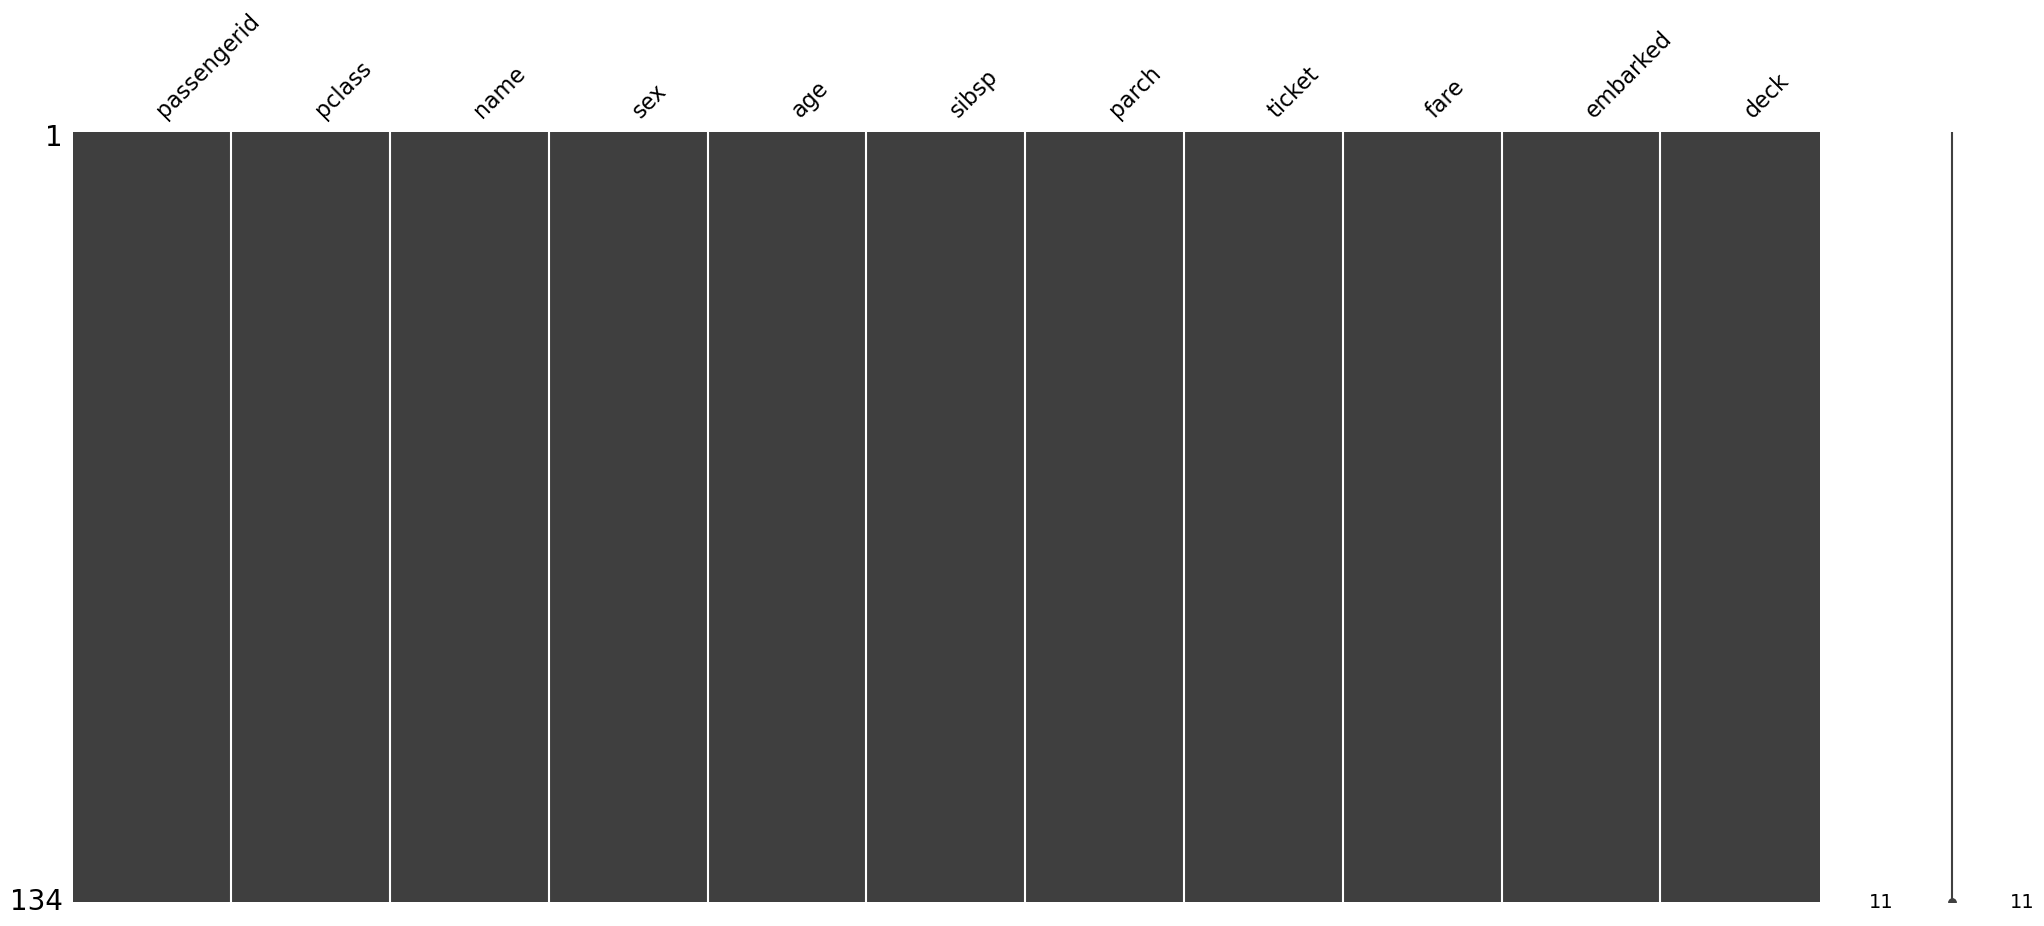

In [134]:
msno.matrix(df)

### iii. Visual on Deck

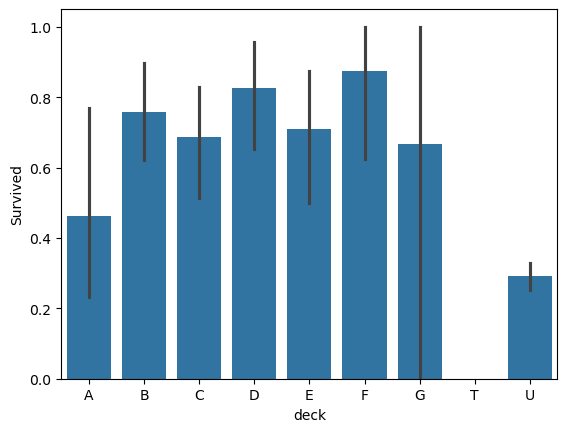

In [136]:
# 1. Create a temporary dataframe that joins X and y together
# Make sure to use the correct index so they align
plot_df = X_train.copy()
plot_df['Survived'] = y_train  # Add the target column back in

# 2. Now plot using this new dataframe
# Note: Check if your target column is named 'Survived' or 'survived'
sns.barplot(
    x='deck', 
    y='Survived', 
    data=plot_df, 
    order=sorted(plot_df['deck'].unique())
)
plt.show()